# Laboratório 10: Modelo para Glucose

### Referente ao capítulo 16

Alguns sistemas de equações diferenciais são sensíveis a mudanças nos parâmetros. Isso pode até levar a falta de convergência, dentre outros problemas. Neste laboratório, examinamos um problema mal condicionado. Em um estudo desenvolvido por Ackerman sobre o sistema regulatório do sangue tinha o objetivo de melhorar a habilidade do teste de tolerância da glucose (GTT) para detectar pré-diabetes e diabetes menos severas. O modelo considera $g$; a concentração de glucose no sangue e $h$; a concentração hormonal líquida. Foi mostrado que 

$$g'(t) = c_1g(t) + c_2h(t)$$
$$h'(t) = c_4g(t) + c_3h(t)$$

Usando propriedades do sangue, é determinado que $c_1, c_2, c_3 < 0$ e $c_4 \ge 0$.  Para diabetes, foi mostrado que $c_4 = 0$ é uma hipótese razoável. O objetivo é encontrar o nível de insulina $u(t)$ que maximiza a diferença entre $g$ e o nível desejado $l$, levando o custo do tratamento. 

$$ \min_u \int_0^T A(g(t) - l)^2 + u(t)^2 dt,$$

$$ g'(t) = -ag(t) - bh(t), g(0) = g_{0} > 0,$$

$$h'(t) = - ch(t) + u(t), h(0) = 0,$$

$$a,b,c > 0, A \geq 0 $$

### Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

## Condições necessárias 

Mais uma vez vamos utilizar a biblioteca simbólica para nos ajudar nos cálculos. Note que esse sistema é tão simples que de fato não seria muito necessário, mas vamos usar assim mesmo. 

### Hamiltoniano

In [2]:
g, h, u, l1, l2, A, l, a, b, c = sp.symbols('g h u l1 l2 A l a b c')
H = A*(g - l)**2 + u**2 + l1*(-a*g - b*h) + l2*(-c*h + u)
H

A*(g - l)**2 + l1*(-a*g - b*h) + l2*(-c*h + u) + u**2

### Condições do Estado

In [3]:
print(sp.diff(H,l1), '\n')
print(sp.diff(H,l2))

-a*g - b*h 

-c*h + u


### Equaçãoes Adjuntas

In [4]:
dl1 = (-1)*sp.diff(H,g)
dl2 = (-1)*sp.diff(H,h)
print(dl1, '\n')
print(dl2)

-A*(2*g - 2*l) + a*l1 

b*l1 + c*l2


### Transversalidade 

$\lambda_1(T) = \lambda_2(T) = 0$

### Otimalidade

In [5]:
eq = sp.Eq(sp.diff(H,u), 0)
sp.solve(eq, u)

[-l2/2]

## Aplicando a classe ao exemplo 

Vamos começar as experimentações

In [6]:
parameters = {'A': None, 'a': None, 'b': None, 'c': None, 'l': None}

diff_state = lambda t, x, u, par: np.array([
    -par['a']*x[0] - par['b']*x[1], 
    -par['c']*x[1] + u[0]
])

diff_lambda = lambda t, x, u, lambda_, par: np.array([ 
    -2*par['A']*(x[0] - par['l']) + par['a']*lambda_[0],
    par['b']*lambda_[0] + par['c']*lambda_[1]
])

update_u = lambda t, x, lambda_, par: -0.5*lambda_[1]

In [7]:
problem = OptimalControl(diff_state, diff_lambda, update_u, 
                         n_controls = 1, n_states = 2)

In [8]:
x0 = np.array([0.75, 0])
T = 20
parameters['A'] = 2
parameters['a'] = 1
parameters['b'] = 1
parameters['c'] = 1
parameters['l'] = 0.5

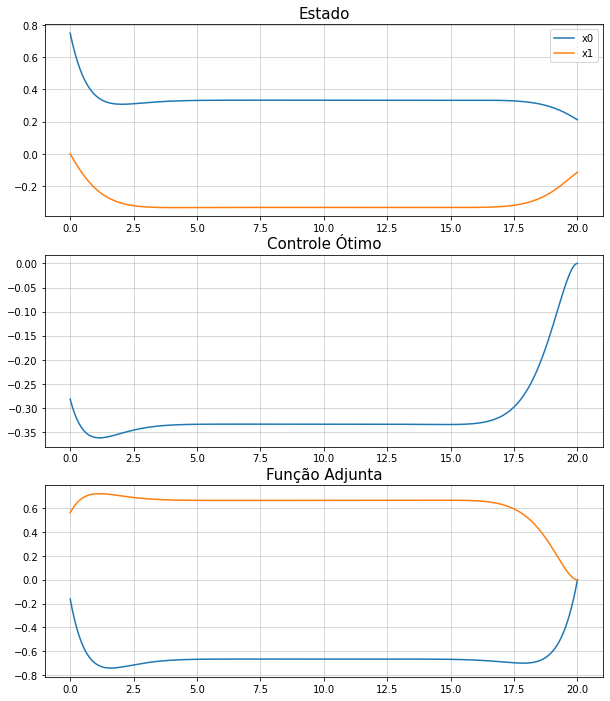

In [9]:
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)
ax[0].legend()
plt.show()

Os resultados são incoerentes. A concentração hormonal e o nível de insulina são ambos negativos no intervalo. Poderíamos ajustar $u(t) \ge 0$, mas isso só levaria para $u^* \equiv 0$. A fonte do problema é na verdade os parâmetros que utilizamos, em particular o comprimento de tempo. O monitoramento desse tipo de teste é em geral em torno de algumas horas e não dias, como estamos considerando. 

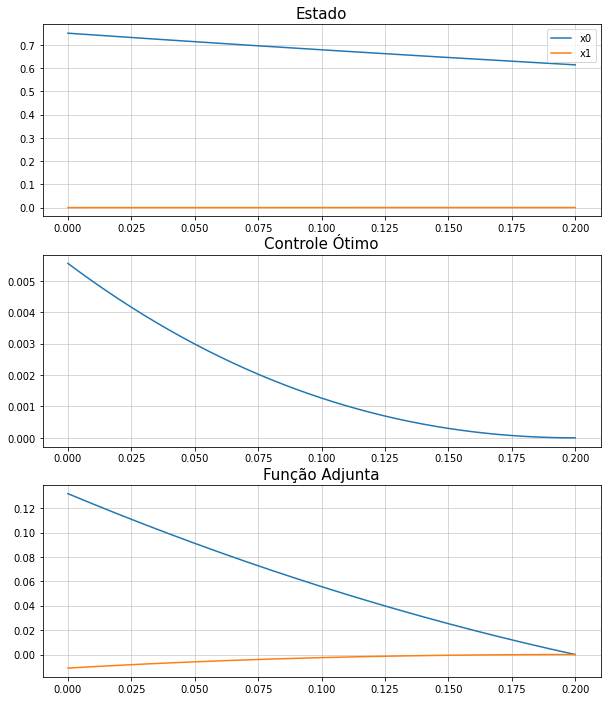

In [10]:
T = 0.2
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)
ax[0].legend()
plt.show()

Agora os resultados estão mais coerentes do que estavam, positivos, pelo menos. A concentração hormonal está na ordem de $10^{-4}$. As escalas estão mais acuradas com relação à realidade também. Vamos comparar a função $h$ com diferentes valores de $T$. 

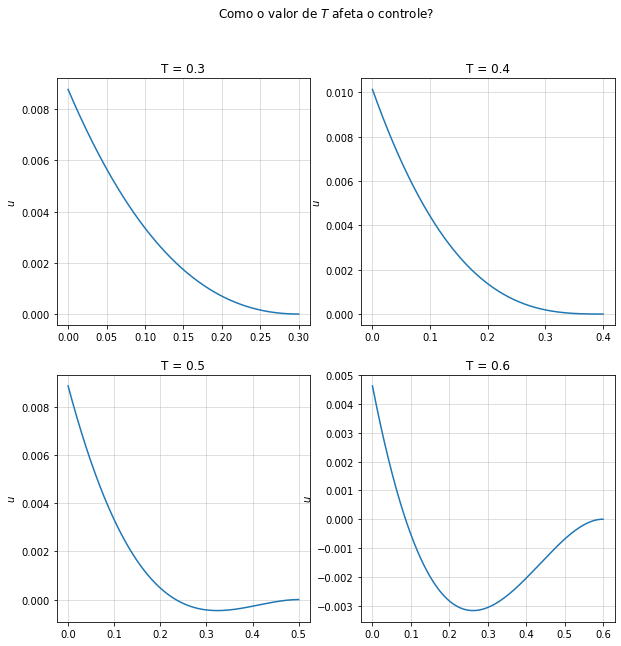

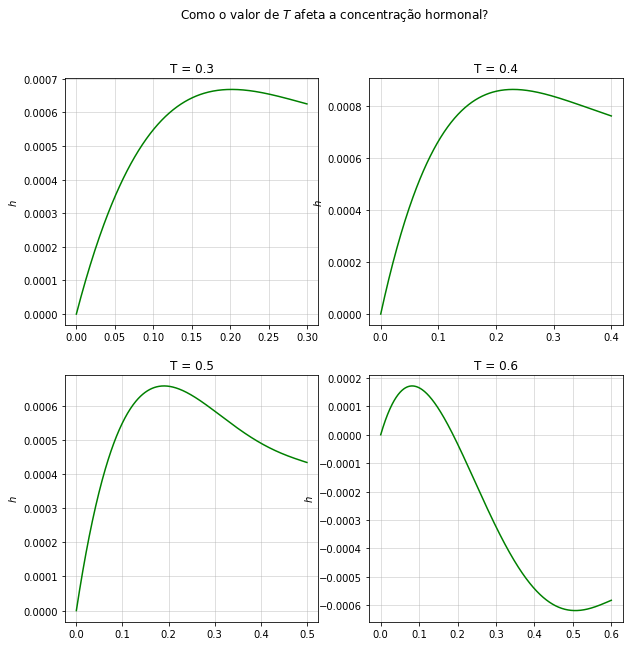

In [11]:
T_values = [0.3, 0.4, 0.5, 0.6]
x_values = []
u_values = []
t_values = []
for T in T_values: 
    t,x,u,_ = problem.solve(x0, T, parameters)
    t_values.append(t)
    x_values.append(x[:,1])
    u_values.append(u)
    
fig, ax = plt.subplots(2,2,figsize = (10,10))
fig.suptitle(r'Como o valor de $T$ afeta o controle?')
for k in range(4):
    i = k//2
    j = k%2
    ax[i][j].set_ylabel(r"$u$")
    ax[i][j].set_title("T = {}".format(T_values[k]))
    ax[i][j].plot(t_values[k], u_values[k])
    ax[i][j].grid(alpha = 0.5)

fig, ax = plt.subplots(2,2,figsize = (10,10))
fig.suptitle(r'Como o valor de $T$ afeta a concentração hormonal?')
for k in range(4):
    i = k//2
    j = k%2
    ax[i][j].set_ylabel(r"$h$")
    ax[i][j].set_title("T = {}".format(T_values[k]))
    ax[i][j].plot(t_values[k], x_values[k], color = 'green')
    ax[i][j].grid(alpha = 0.5)

Observe que para $T = 0.5$, o que equivale a 12h, já temos valores negativos que não aproximam a realidade. A proposta desse laboratório foi ilustrar a necessidade de escolher parâmetros razoáveis para a situação. Procurar na literatura é sempre o primeiro passo. 